In [5]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
def read_csv(path):
    df = pd.read_csv(path)
    df = df[['height', 'temp', 'rainfallh']]
    df.dropna()
    return format_data(df)


def format_data(df):
    height2, predictors = get_split(df)
    predictors = predictors.shift(-1)[0:len(predictors)-1]
    df['single_input_vector'] = predictors.apply(tuple, axis=1).apply(list)
    df.single_input_vector[len(df)-1] = [0,0]
    # Double-encapsulate list so that you can sum it in the next step and keep time steps as separate elements
    df['single_input_vector'] = df.single_input_vector.apply(lambda x: [list(x)])
    df['cumulative_input_vectors'] = df.single_input_vector.cumsum()
    max_sequence_length = df.cumulative_input_vectors.apply(len).max()
    padded_sequences = pad_sequences(df.cumulative_input_vectors.tolist(), max_sequence_length).tolist()
    df['padded_input_vectors'] = pd.Series(padded_sequences).apply(np.asarray)
    print(len(df))
    X_train_init = np.asarray(df.padded_input_vectors)
    print(X_train_init.shape)
    s = np.hstack(X_train_init)
    fin = s.reshape(len(df),len(df),2)
    y_train = np.hstack(np.asarray(height2))
    return fin, y_train


def get_split(dataset):
    #print(dataset.drop('height',1))
    return dataset['height'], dataset.drop('temp',1)

X_train, y_train = read_csv('../input/height.csv')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


3535
(3535,)


Now let's build the model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras import callbacks
import numpy as np
import random
import sys

def build_lstm_model():

    model = Sequential()

    model.add(LSTM(
        input_shape=(None,2),
        units=20,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        50,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        1))
    model.add(Activation("linear"))
    
    model.compile(loss="mse", optimizer="rmsprop")
    return model

callback =callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)



In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Flatten
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras import callbacks
import numpy as np
import random
import sys

def build_plain_model():
    model = Sequential()
    model.add(Flatten(batch_input_shape=(None,3535,2)))
    model.add(Dense(20,activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(
        50,
        activation="relu"))
    model.add(Dropout(0.2))
    

    model.add(Dense(
        1))
    model.add(Activation("linear"))
    
    model.compile(loss="mse", optimizer="rmsprop")
    #print("> Compilation Time : ", time.time() - start)
    return model

callback =callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)



In [8]:

model_plain = build_plain_model()
print(model_plain.summary())
model_plain.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=20,
    validation_split=0.2, 
    callbacks=[callback])

model_lstm = build_lstm_model()
print(model_lstm.summary())
model_lstm.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=5,
    validation_split=0.2, 
    callbacks=[callback])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 7070)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                141420    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)      

In [12]:
X_test, y =read_csv("../input/height.csv")
#y_pred=predict_sequences_multiple(model,X_test,10,100)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


3535
(3535,)


In [14]:

y_pred_lstm=model_lstm.predict(X_test)
y_pred_plain=model_plain.predict(X_test)

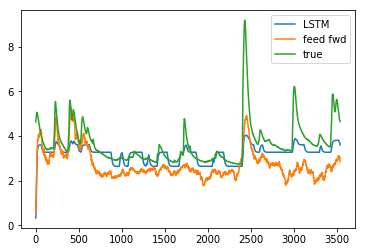

In [15]:
# The actual values
import matplotlib.pyplot as plt
plt.plot(range(len(y_pred_lstm)),y_pred_lstm,label="LSTM")
plt.plot(range(len(y_pred_plain)),y_pred_plain,label="feed fwd")
plt.plot(range(len(y)),y,label="true")
plt.legend()